In [1]:
import pandas as pd
import numpy as np
import difflib
from fuzzywuzzy import fuzz

def append_row(df, row):
    return pd.concat([
                df, 
                pd.DataFrame([row], columns=row.index)]
           ).reset_index(drop=True)
                         

In [2]:
df_names = pd.read_csv('people_in_S4S.csv',index_col='Index')
# df_names['fullname_abb'] = df_names['firstname'].apply(lambda x: x[0].upper() + '.') + ' ' + df_names['lastname']
del df_names['faculty'], df_names['department']

In [3]:
#read and format the PURE data
col_names = ['solisID','pureID','lastname','firstname', 'scopusID','orcID', 'jobtitle','organisationalUnit','numberResearchOutputs','sampleTitle','sampleDOI','sampleType']
df_pure = pd.read_excel('pure_data.xlsx',names=col_names,keep_default_na='')
df_pure['firstname'] = df_pure['firstname'].apply(lambda x: 'no firstname' if len(str(x)) == 0 else str(x).split(',')[-1].strip()+ ' ')
df_pure['fullname'] = df_pure['firstname'] + df_pure['lastname']
df_pure.fillna('',inplace=True)

c:\Users\torbj\.conda\envs\newenv\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
#using fuzzywuzzy to compare names on the list (people_in_S4S) with people in PURE. 
tuples_list = [max([(fuzz.token_set_ratio(i,j),j) for j in df_pure['fullname']]) for i in df_names['fullname']]

In [10]:
similarity_score, fuzzy_match = map(list,zip(*tuples_list))
df_fuzzymatch = pd.DataFrame({"fullname":df_names['fullname'], "fuzzyMatch": fuzzy_match, "similarityScore":similarity_score,'source':df_names['source']})
df_fuzzymatch['fuzzyMatch'] = df_fuzzymatch['fuzzyMatch'].apply(lambda x: str(x).strip())

#the list loaded in the next line is a list which involved the manual lookup of names (with low similarity scores)
# df_lookup = pd.read_csv("lookup_table_new.csv",encoding='utf-16',delimiter='\t',index_col=[0]).sort_index()
# df_fuzzymatch['note'] = df_lookup['note']

In [11]:
df_fuzzymatch = df_fuzzymatch[df_fuzzymatch['similarityScore'] > 95]
df_fuzzymatch.drop_duplicates(subset='fuzzyMatch',keep='first',inplace=True)
df_fuzzymatch.reset_index(drop=True,inplace=True)


In [12]:

df_reduced = df_pure.set_index('fullname').loc[df_fuzzymatch['fuzzyMatch'].to_list()].reset_index()
df_reduced = df_reduced.drop_duplicates('fullname').sort_index() #sort_values('numberResearchOutputs', ascending=False
df_reduced.reset_index(drop=True,inplace=True)
df_reduced['source'] = df_fuzzymatch['source']

df_reduced.to_csv('people_in_S4S_pureFiltered.csv',index_label='Index')


retrieving author information (similar to retrieve_orcid_scopusid.ipynb)

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
import json
client_orcid = open('orcid_config.json')
client_orcid = json.load(client_orcid)

client_scopus = open('scopus_config.json')
client_scopus = json.load(client_scopus)

df_persons = df_reduced

#orcid start up
client_id = client_orcid['client_id']
client_secret = client_orcid['client_secret']

resp = requests.post(url="https://orcid.org/oauth/token",
                     headers={'Accept':'application/json'},
                     data={'client_id':client_id, 'client_secret':client_secret,'grant_type': 'client_credentials', 'scope':'/read-public'}
                     )
access_token = resp.json()['access_token']


(1) Take scopusId provided by PURE

(2) Retrieve scopusId with doi

In [202]:
for i in tqdm(df_persons[df_persons['scopusId'] == ''].index):
    # if df_persons['sampleDoi'][i] != '':
    first_name = df_persons['firstname'][i].strip()
    last_name = df_persons['lastname'][i].strip()

    resp = requests.get(url=f'http://api.elsevier.com/content/search/author?query=AUTHLASTNAME({last_name})+AND+AUTHFIRST({first_name})+AND+AFFIL(Utrecht)', 
            headers={'X-ELS-APIKey':client_scopus['apikey'], 'X-ELS-Insttoken':client_scopus['insttoken'], 'accept':'application/json'},)
    try:
        #saving the scopusid
        scopus_id = resp.json()['search-results']['entry'][0]['dc:identifier'][10:]
        df_persons['scopusId'].loc[i] = scopus_id
    except:
        df_persons['scopusId'].loc[i] = ''


        #see if there is an orcid associated
    try:
        orcid =  resp.json()['search-results']['entry'][0]['orcid']
        df_persons['orcid'].loc[i] = orcid            
    except:
        df_persons['orcid'].loc[i] = ''  


100%|██████████| 109/109 [02:03<00:00,  1.13s/it]


In [302]:
df_persons.to_csv('person_names_from_pure.csv')


(3) Retrieve scopusId with NAME and AFFIL and KEYWORD(?)

FIGURES

In [241]:
df_persons = pd.read_csv('person_names_from_pure.csv',keep_default_na=False,index_col=[0])


In [243]:
import plotly.graph_objects as go

# Define nodes
nodes = ["Mailinglist",     #0
         "Website",         #1
         "In Pure",         #2
         "Not in Pure",     #3
         "In Scopus",       #4
         "Not in Scopus"]   #5

# Define links
links = [
    {"source": 0, "target": 2, "value": len(df_persons[df_persons['source'] =='mailinglist'])},  # Mailinglist True -> In Pure True
    {"source": 0, "target": 3, "value": len(df_names[df_names['source'] =='mailinglist']) - len(df_persons[df_persons['source'] =='mailinglist'])},   # Mailinglist True -> In Pure False
    {"source": 1, "target": 2, "value": len(df_persons[df_persons['source'] =='website'])},  # Mailinglist False -> In Scopus True
    {"source": 1, "target": 3, "value": len(df_names[df_names['source'] =='website']) - len(df_persons[df_persons['source'] =='website'])},  # Mailinglist False -> In Scopus False
    {"source": 2, "target": 4, "value": len(df_persons[df_persons['scopusId'] !=''])},   # Website True -> In Pure True
    {"source": 2, "target": 5, "value": len(df_persons[df_persons['scopusId'] ==''])},  # Website True -> In Pure False
    {"source": 3, "target": 4, "value": 0},   # Website False -> In Scopus True
    {"source": 3, "target": 5, "value": len(df_names)-len(df_persons)}   # Website False -> In Scopus False
]

# Create the Sankey diagram
# fig.update_layout(title_text="S4S people")
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=25,
        thickness=30,
        # line=dict(color="black", width=0.5),
        # label=nodes,
        color = ["skyblue","violet","#8ED973","salmon",'forestgreen','firebrick']
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links],
        # color='lightgrey'
   )
)],
   layout=go.Layout(autosize=False,
    width=1200,
    height=700,))
# color_for_nodes = ["skyblue","violet","#8ED973","salmon",'forestgreen','firebrick']
# fig.update_traces(node_color = color_for_nodes)




fig.show()
fig.write_html("plots/sankey_peopleS4S.html")


PLOTTING TO CHART STUDIO (IN ORDER TO EMBED THE WEBVIEW INTO POWERPOINT)

In [298]:
import chart_studio
chart_studio.tools.set_credentials_file(username='Tkagel', api_key='GzCJTnpLg05gfCd1hBUD')

In [300]:
import chart_studio.plotly as py
test = data=[go.Sankey(
    node=dict(
        pad=25,
        thickness=30,
        # line=dict(color="black", width=0.5),
        label=nodes,
        color = ["skyblue","violet","#8ED973","salmon",'forestgreen','firebrick']
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links],
        # color='lightgrey'
   )
)]
py.plot(test, filename = 'basic-line', auto_open=True)

'https://plotly.com/~Tkagel/1/'

JOB TITLE PLOT

In [148]:
import matplotlib.pyplot as plt
df_lookup = pd.read_csv('lookup_table_new.csv',encoding='utf-16',delimiter='\t',index_col=[0]).sort_index()
df_roles = df_lookup
df_roles['role'] = df_lookup['note']
test_list = (df_roles['role'] == 'correct match').to_list()
k=0
for i in range(len(test_list)):
    if test_list[i] == True:
        test_list[i] = df_reduced['jobTitle'].loc[k]
        k+=1
    if test_list[i] == False:
        test_list[i] = df_roles['role'].loc[i]
        
df_roles['role'] = test_list
df_roles.to_csv('person_roles.csv',encoding='utf-16')

In [151]:
df_roles = pd.read_csv('person_roles.csv',encoding='utf-16',delimiter='\t')


In [155]:
df_roles['role']

0             Assistant Professor
1                     PhD Student
2                      Researcher
3                          Decaan
4             Assistant Professor
                  ...            
264                   PhD Student
265                     not at UU
266                       Student
267    Education/Research Officer
268                     not at UU
Name: role, Length: 269, dtype: object

In [162]:
df_roles['role'].apply(lambda x: str(x).strip())

0             Assistant Professor
1                     PhD Student
2                      Researcher
3                          Decaan
4             Assistant Professor
                  ...            
264                   PhD Student
265                     not at UU
266                       Student
267    Education/Research Officer
268                     not at UU
Name: role, Length: 269, dtype: object

In [187]:

counted_roles = df_roles['role'].apply(lambda x: str(x).strip()).value_counts()
counted_roles_plot = counted_roles[counted_roles > 5]
counted_roles_plot.loc['Misc']  = counted_roles[counted_roles <= 5].sum()




In [199]:
counted_roles_df = pd.DataFrame(counted_roles_plot)
counted_roles_df['order'] = [3,8,5,1,2,7,6,9,4,10,0]
counted_roles_df.reset_index(inplace=True)
counted_roles_df.set_index('order',inplace=True)
counted_roles_df.sort_index(inplace=True)

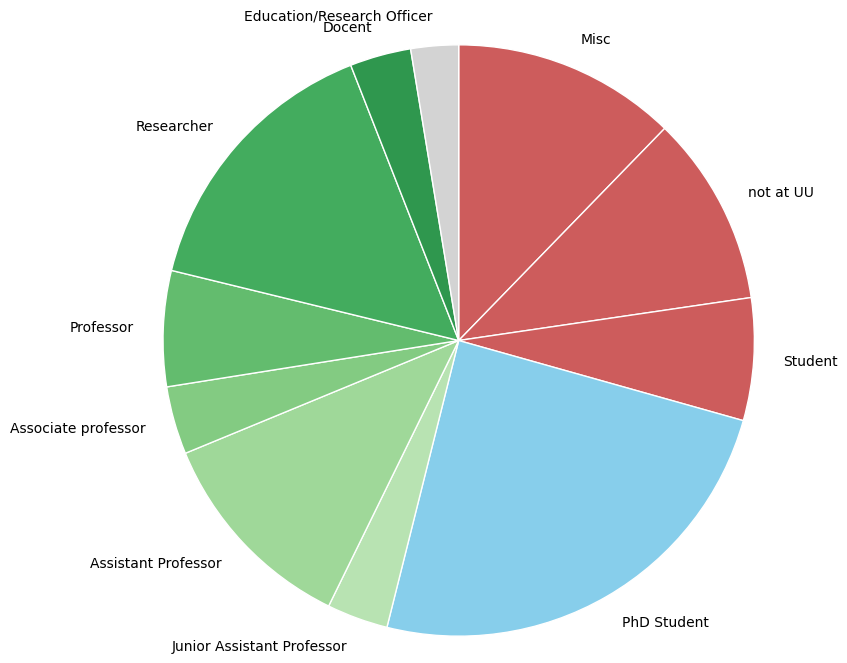

In [230]:
color_lookup = plt.cm.Greens(np.linspace(0.3,0.7,6))
plt.pie(counted_roles_df['count'],
        startangle=90,
        counterclock=False,
        labels=counted_roles_df['role'],
        labeldistance=1.1,
        radius=2,
        colors=['indianred','indianred','indianred','skyblue',color_lookup[0],color_lookup[1],color_lookup[2],color_lookup[3],color_lookup[4],color_lookup[5],'lightgrey'],
        wedgeprops={"edgecolor":"white",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True}

        );